In [1]:
#main libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
#vectorizors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [3]:
#metrics
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [4]:
#modules for building ML model
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cross_validation import cross_val_score

C:\Users\Aravindh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Objective

1. sort the data time based

2. sample equal amount of data points in both +ve and -ve reviews

3. Build knn with featurisation techniques like BOW, TFIDF AVGW2V2 TFIDFW2V

4. Find optimal 'k'

5. Find accuracy score on test data.

In [5]:
#connect sql database
con = sqlite3.connect('final.sqlite')

In [6]:
#read sql data using pandas
data = pd.read_sql("SELECT * FROM REVIEWS", con)

In [7]:
def partition(x) :
    if x == 'positive' :
        return 1
    return 0

actualscore = data['Score']
positivenegative = actualscore.map(partition)
data['Score'] = positivenegative

In [8]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


Number of positive & negative data points are 
 1    307061
0     57110
Name: Score, dtype: int64


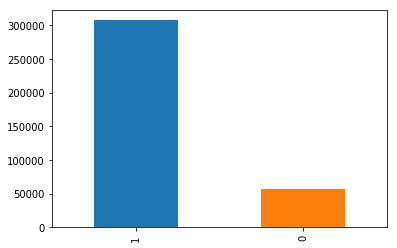

In [9]:
print ('Number of positive & negative data points are \n',data['Score'].value_counts())
data['Score'].value_counts().plot(kind='bar')

In [10]:
#sort data based on time
df_time_sorted = data.sort_values('Time', kind ='quicksort')

In [11]:
df_time_sorted.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


The important piece of information from dataset for building ML models are text reviews and their Scores if they are positive or negative so lets seperate only those two columns into a seperate dataframe using pandas

In [12]:
df = pd.DataFrame(data, columns=['CleanedText', 'Score'])
df.head()

,CleanedText,Score
0,witti littl book make son laugh loud recit car...,1
1,grew read sendak book watch realli rosi movi i...,1
2,fun way children learn month year learn poem t...,1
3,great littl book read nice rhythm well good re...,1
4,book poetri month year goe month cute littl po...,1


In [13]:
#lets check the total dataset values
df.shape

(364171, 2)

Number of +ve & -ve datapoints 
 1    21204
0     3796
Name: Score, dtype: int64


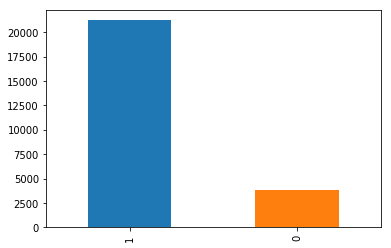

In [14]:
df_sample = df.head(25000)
print ('Number of +ve & -ve datapoints \n' ,df_sample['Score'].value_counts())
df_sample['Score'].value_counts().plot(kind='bar')

In [15]:
X = df_sample['CleanedText']
y = df_sample['Score']
print (X.shape)
print (y.shape)

(25000,)
(25000,)


In [16]:
#test-train-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=0)
print('X_train shape :' ,X_train.shape)
print('y_train shape :' ,y_train.shape)
print('X_test shape :' ,X_test.shape)
print('y_test shape :' ,y_test.shape)

X_train shape : (17500,)
y_train shape : (17500,)
X_test shape : (7500,)
y_test shape : (7500,)


# BAG of WORDS

In [17]:
vect = CountVectorizer()

In [18]:
from sklearn import preprocessing
bow_X_train = vect.fit_transform(X_train)
bow_X_train = preprocessing.normalize(bow_X_train)
bow_X_train

<17500x18439 sparse matrix of type '<class 'numpy.float64'>'
	with 553493 stored elements in Compressed Sparse Row format>

In [19]:
bow_X_test = vect.transform(X_test)
bow_X_test = preprocessing.normalize(bow_X_test)
bow_X_test

<7500x18439 sparse matrix of type '<class 'numpy.float64'>'
	with 236061 stored elements in Compressed Sparse Row format>

In [78]:
def best_params_search_brute(X_train, y_train) :
    n_neighbors = list(range(1,100,2))
    cv_scores = []
    for k in n_neighbors :
        clf = KNeighborsClassifier(n_neighbors=k, algorithm='brute', n_jobs=-1)
        scores = cross_val_score(clf, X_train, y_train, cv=5, verbose=1, n_jobs=-1)
        cv_scores.append(scores.mean())
    #plot misclassification error
    MSE = [1-x for x in cv_scores]
    #select K with lower MSE error.
    best_k = n_neighbors[MSE.index(min(MSE))] #get index where MSE error is lower and get the K value from the index of n_neighbours
    print('Best hyper parameters are:' ,best_k)
    #Function for cv_error vs n_neighbor plot
    plt.figure(figsize=(10,6))
    plt.xlabel('K in KNN')
    plt.ylabel('Misclassification Error')
    plt.plot(n_neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
    return best_k

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished
[Paral

Best hyper parameters are: 11


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


11

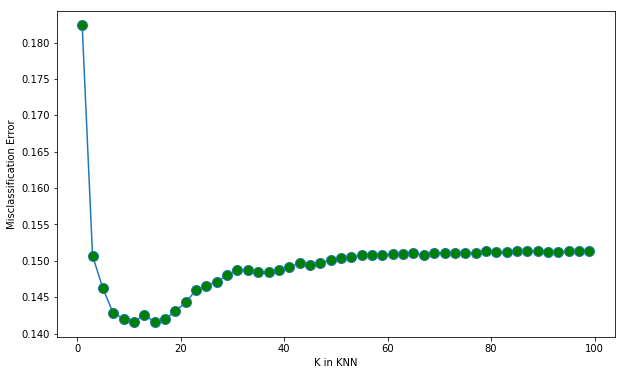

In [79]:
best_params_search_brute(bow_X_train, y_train)

In [89]:
def knn_brute(n_neighbors, X_train, y_train, X_test) :
    clf = KNeighborsClassifier(n_neighbors = n_neighbors, algorithm='brute', n_jobs = -1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print ('accuracy score :' ,metrics.accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')

accuracy score : 0.8613333333333333
Wall time: 9.76 s


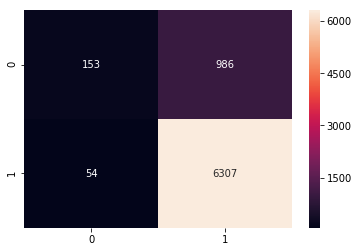

In [90]:
%time knn_brute(11, bow_X_train, y_train, bow_X_test)

In [82]:
def best_params_search_kdtree(X_train, y_train) :
    n_neighbors = list(range(1,30,2))
    cv_scores = []
    for k in n_neighbors :
        clf = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree', n_jobs=-1)
        scores = cross_val_score(clf, X_train, y_train, cv=5, verbose=1, n_jobs=-1)
        cv_scores.append(scores.mean())
    #plot misclassification error
    MSE = [1-x for x in cv_scores]
    #select K with lower MSE error.
    best_k = n_neighbors[MSE.index(min(MSE))] #get index where MSE error is lower and get the K value from the index of n_neighbours
    print('Best hyper parameters are:' ,best_k)
    #Function for cv_error vs n_neighbor plot
    plt.figure(figsize=(10,6))
    plt.xlabel('K in KNN')
    plt.ylabel('Misclassification Error')
    plt.plot(n_neighbors, MSE, marker='o',markerfacecolor='green', markersize=10)
    return best_k

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


Best hyper parameters are: 11


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


11

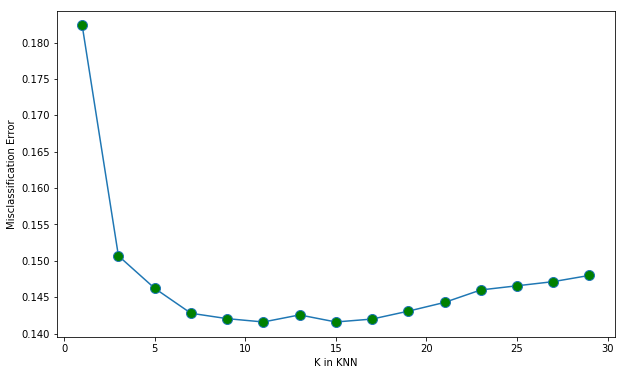

In [83]:
best_params_search_kdtree(bow_X_train, y_train)

In [85]:
def knn_kdtree(n_neighbors, X_train, y_train, X_test) :
    clf = KNeighborsClassifier(n_neighbors = n_neighbors, algorithm='kd_tree', n_jobs = -1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print ('accuracy score :' ,metrics.accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')

accuracy score : 0.8613333333333333
Wall time: 9.64 s


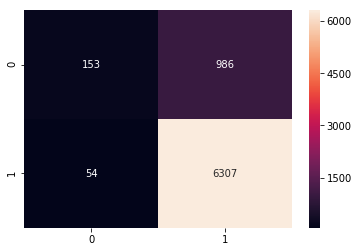

In [87]:
%time knn_kdtree(11, bow_X_train, y_train, bow_X_test)

# TFIDF

In [92]:
vect = TfidfVectorizer()

In [93]:
from sklearn import preprocessing
tfidf_X_train = vect.fit_transform(X_train)
tfidf_X_train = preprocessing.normalize(bow_X_train)
tfidf_X_train

<17500x18439 sparse matrix of type '<class 'numpy.float64'>'
	with 553493 stored elements in Compressed Sparse Row format>

In [94]:
tfidf_X_test = vect.transform(X_test)
tfidf_X_test = preprocessing.normalize(bow_X_test)
tfidf_X_test

<7500x18439 sparse matrix of type '<class 'numpy.float64'>'
	with 236061 stored elements in Compressed Sparse Row format>

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished
[Paral

Best hyper parameters are: 11


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished


11

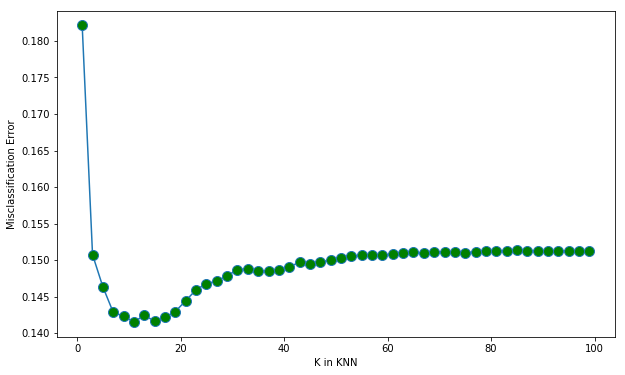

In [96]:
best_params_search_brute(tfidf_X_train, y_train)

accuracy score : 0.8613333333333333
Wall time: 9.69 s


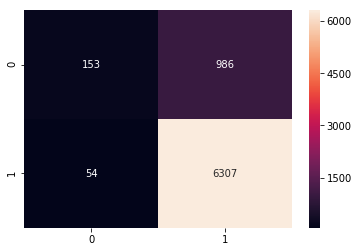

In [98]:
%time knn_brute(11, tfidf_X_train, y_train, tfidf_X_test)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.2s finished


Best hyper parameters are: 11


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


11

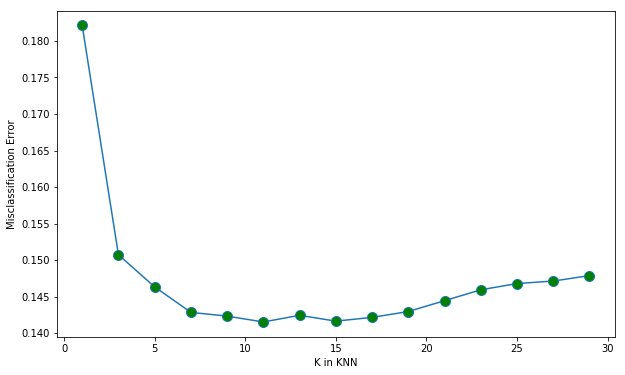

In [100]:
best_params_search_kdtree(tfidf_X_train, y_train)

accuracy score : 0.8613333333333333
Wall time: 9.68 s


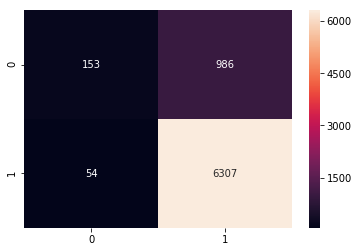

In [101]:
%time knn_kdtree(11, tfidf_X_train, y_train, tfidf_X_test)

# WORD2VECTOR Model

In [141]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [142]:
print(X_train.values[0])
print("*****************************************************************")
print(list_of_sent[0])

dog refus eat smell pretti bad cant recommend treat dog refus touch
*****************************************************************
['dog', 'refus', 'eat', 'smell', 'pretti', 'bad', 'cant', 'recommend', 'treat', 'dog', 'refus', 'touch']


In [143]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [144]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6421
sample words  ['dog', 'refus', 'eat', 'smell', 'pretti', 'bad', 'cant', 'recommend', 'treat', 'touch', 'two', 'household', 'day', 'littl', 'worri', 'order', 'lbs', 'wasabi', 'pea', 'howev', 'needless', 'fresh', 'delici', 'theyr', 'near', 'gone', 'ill', 'soon', 'yummi', 'huski', 'puppi', 'love', 'perfect', 'size', 'train', 'even', 'though', 'small', 'still', 'usual', 'cut', 'half', 'get', 'longer', 'session', 'amaz', 'want', 'addict', 'candi', 'realli']


# AVGW2V

### AVGW2V on train data

In [116]:
%time
# average Word2Vec
# compute average word2vec for each review.
train_vectors = []; # the avg-w2v for each sentence/review is stored in this li
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_vectors.append(sent_vec)
print(len(train_vectors))
print(len(train_vectors[0]))

Wall time: 0 ns
17500
50


In [117]:
avgw2v_train = preprocessing.normalize(train_vectors)

### AVGW2V on test data

In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent_in_test=[]
for sent in X_test.values:
    list_of_sent_in_test.append(sent.split())

In [125]:
print(X_test.values[0])
print("*****************************************************************")
print(list_of_sent_in_test[0])

love stuff use much stuff buy jug dissolv easier fluid powder also use extract two product raw vanilla bean powder eat vanilla like food group ive vanilla bean past okay one bomb
*****************************************************************
['love', 'stuff', 'use', 'much', 'stuff', 'buy', 'jug', 'dissolv', 'easier', 'fluid', 'powder', 'also', 'use', 'extract', 'two', 'product', 'raw', 'vanilla', 'bean', 'powder', 'eat', 'vanilla', 'like', 'food', 'group', 'ive', 'vanilla', 'bean', 'past', 'okay', 'one', 'bomb']


In [126]:
# average Word2Vec
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in list_of_sent_in_test : # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_vectors.append(sent_vec)
print(len(test_vectors))
print(len(test_vectors[0]))

7500
50


In [127]:
avgw2v_test = preprocessing.normalize(test_vectors)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.7s finished


Best hyper parameters are: 23


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


23

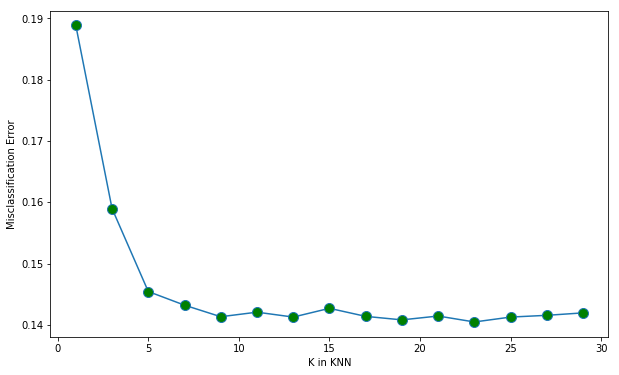

In [130]:
best_params_search_kdtree(avgw2v_train, y_train)

accuracy score : 0.862
Wall time: 3.51 s


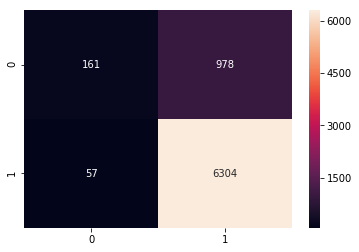

In [131]:
%time knn_kdtree(23, avgw2v_train, y_train, avgw2v_test)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.2s finished
[Paral

Best hyper parameters are: 23


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.4s finished


23

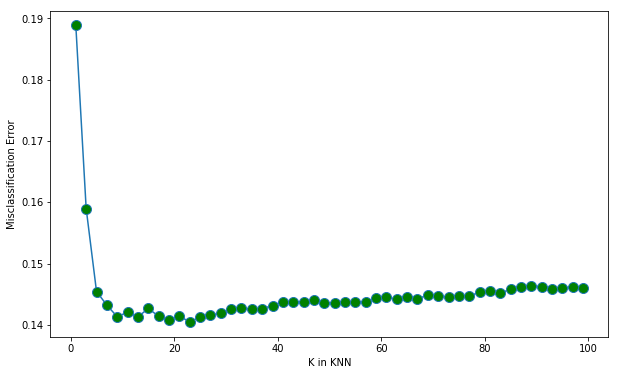

In [132]:
best_params_search_brute(avgw2v_train, y_train)

accuracy score : 0.862
Wall time: 9.4 s


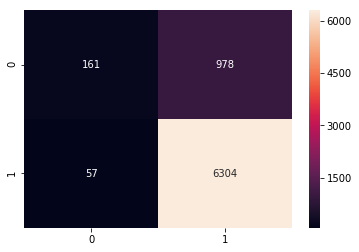

In [133]:
%time knn_brute(23, avgw2v_train, y_train, avgw2v_test)

# TFIDFW2V

### TFIDFW2V on Train data

In [145]:
#calculate TFIDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_train.values)

In [146]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
print(len(tfidf_train_vectors))
print(len(tfidf_train_vectors[0]))

17500
50


In [155]:
tfidfw2v_train = preprocessing.normalize(tfidf_train_vectors)
tfidfw2v_train.shape

(17500, 50)

### TFIDFW2V on Test Data

In [147]:
#calculate TFIDF
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_test.values)

In [148]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
np.seterr(divide='ignore', invalid='ignore')
tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_in_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
print(len(tfidf_test_vectors))
print(len(tfidf_test_vectors[0]))


7500
50


In [154]:
tfidfw2v_test = preprocessing.normalize(tfidf_test_vectors)
tfidfw2v_test.shape

(7500, 50)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.8s finished
[Paral

Best hyper parameters are: 19


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


19

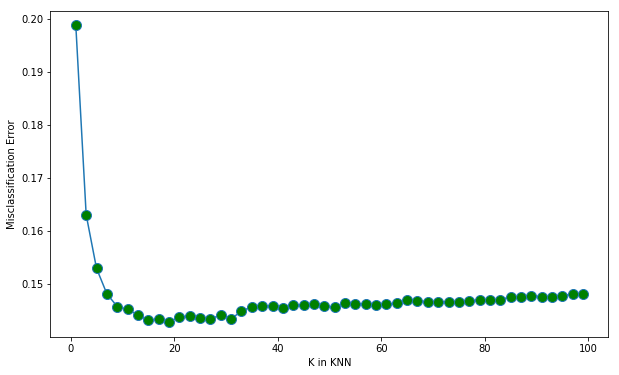

In [156]:
best_params_search_brute(tfidfw2v_train, y_train)

accuracy score : 0.8566666666666667
Wall time: 7.08 s


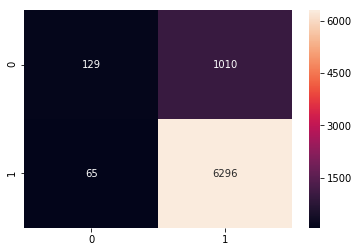

In [158]:
%time knn_brute(19, tfidfw2v_train, y_train, tfidfw2v_test)

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Best hyper parameters are: 19


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


19

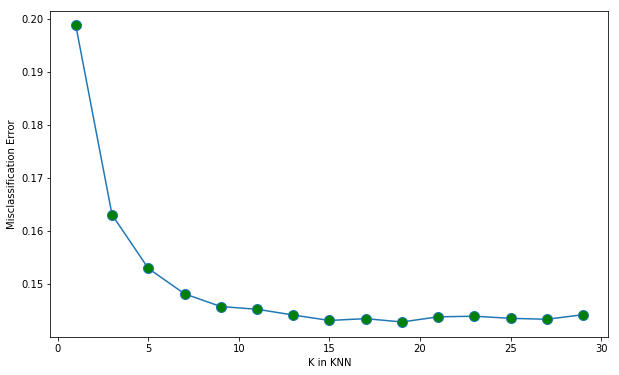

In [159]:
best_params_search_kdtree(tfidfw2v_train, y_train)

accuracy score : 0.8566666666666667
Wall time: 1.92 s


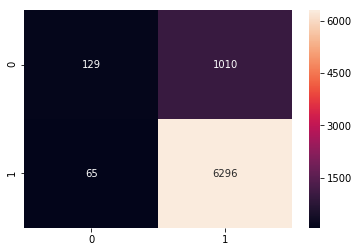

In [160]:
%time knn_kdtree(19, tfidfw2v_train, y_train, tfidfw2v_test)

# RESULTS

In [234]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["MODEL", "BEST K", "ACCURACY", "TP & TN", "REMARKS" ]
#BOW
x.add_row(['BOW with BRUTE', 11, 0.86, 6460, '986 Negative points are wrongly classified as positives'])
x.add_row(["BOW with KD_Tree", 11 , 0.86, 6460, '986 Negative points are wrongly classified as positives'])
x.add_row(['--'*5,'-'*5,'-'*8,'-'*5, '--'*30])
#TFIDF
x.add_row(['TFIDF with BRUTE', 11, 0.86, 6460, '986 Negative points are wrongly classified as positives'])
x.add_row(["TFIDF with KD_Tree", 11 , 0.86, 6460, '986 Negative points are wrongly classified as positives'])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*30])
#AVGW2V
x.add_row(['AVGW2V with BRUTE', 23, 0.86, 6465, '978 Negative points are wrongly classified as positives'])
x.add_row(["AVGW2V with KD_Tree", 23 , 0.86, 6465, '978 Negative points are wrongly classified as positives'])
x.add_row(['--'*5,'-'*8,'-'*8,'-'*5, '--'*30])
#TFIDFW2V
x.add_row(['TFIDFW2V with BRUTE', 19, 0.856, 6425, '1010 Negative points are wrongly classified as positives' ])
x.add_row(["TFIDFW2V with KD_Tree", 19 , 0.856, 6425, '1010 Negative points are wrongly classified as positives'])
print(x)

+-----------------------+----------+----------+---------+--------------------------------------------------------------+
|         MODEL         |  BEST K  | ACCURACY | TP & TN |                           REMARKS                            |
+-----------------------+----------+----------+---------+--------------------------------------------------------------+
|     BOW with BRUTE    |    11    |   0.86   |   6460  |   986 Negative points are wrongly classified as positives    |
|    BOW with KD_Tree   |    11    |   0.86   |   6460  |   986 Negative points are wrongly classified as positives    |
|       ----------      |  -----   | -------- |  -----  | ------------------------------------------------------------ |
|    TFIDF with BRUTE   |    11    |   0.86   |   6460  |   986 Negative points are wrongly classified as positives    |
|   TFIDF with KD_Tree  |    11    |   0.86   |   6460  |   986 Negative points are wrongly classified as positives    |
|       ----------      | ------

In [233]:
#number of positive and negative values in test data
y_test.value_counts()

1    6361
0    1139
Name: Score, dtype: int64

**OBSERVATIONS**

using my system the maximum points i can sample turns out to be 25K. beyond that i recieve memory error.

1. the test error is showing same over all the vectorisations but actual results are known by seeing confusion matrix.


2. confusion matrix = [tn fp] [fn tp]

        tn - actual class and predicted class are both negative

        tp - actual class and predicted class are both positive

        fn - actual class is positive but model wrongly classified as negative[Falsdely classified negative data points]

        fp - actual class is negative model,wrongly classified as positive. [falsely classified


3. out of 7500 points in test data using all vectorizors, roughly 1K points are falsely predicted as positive. while their actual class is negative.


4. to be precise out of 1139 negative points in test data, approximately 95% of points are classified as positive


4. this current model is so much biased towards positive data since large amount of points belongs to positive class. this can be little bit solved using upsampling.